In [1]:
import os
import time
from typing import *
import random
from dataclasses import dataclass

import h5py
import pandas
import numpy as np
import scipy.stats.mstats
import scipy.optimize
import astropy
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
from matplotlib import pyplot as plt
from matplotlib import colors

from illustris_python.snapshot import loadHalo
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import emcee
import corner

Choose the `simulation.hdf5` file



In [2]:
dir = "../TNG100-3-Dark/"
file = "simulation.hdf5"
path = os.path.join(dir, file)

Read the `simulation.hdf5` file

In [3]:
data = h5py.File(path)

<ipython-input-3-e83e8f9293ba>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  data = h5py.File(path)


Helper functions

In [4]:
def comoving_to_physical(comoving, z=0, h=data['Header'].attrs['HubbleParam']):
    return comoving/h/1000*(1/(1+z))

def density_to_physical(
        density, bins,
        dm_mass=data['Header'].attrs['MassTable'][1],
):
    binsize = 1/bins**2  # todo
    return density * dm_mass / binsize

xyzdict={0:"X, Mpc", 1:"Y, Mpc", 2:"Z, Mpc"}

In [5]:
# Fine
snapshots = ["4", "17", "33", "50", "99"]
bins_list = [300]
particle_sampling = 10
# Dirty
bins_list = [300]
particle_sampling = 10

In [6]:
data['Snapshots']["99"]["Header"].attrs["Redshift"]

2.220446049250313e-16

In [7]:
snapshots_read = {}

for sn_id in snapshots:
    snapshot = data['Snapshots'][sn_id]
    snapshots_read[sn_id] = comoving_to_physical(
        snapshot['PartType1']['Coordinates'][::particle_sampling,:],
        z=snapshot["Header"].attrs["Redshift"]
    )

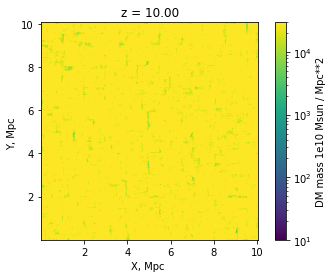

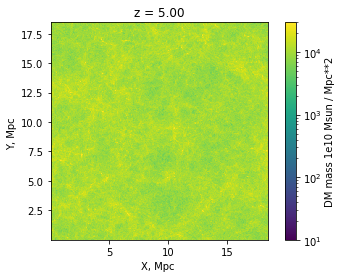

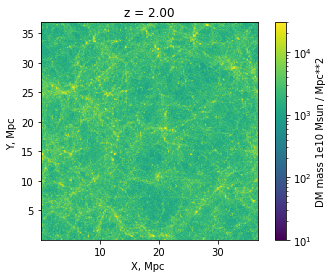

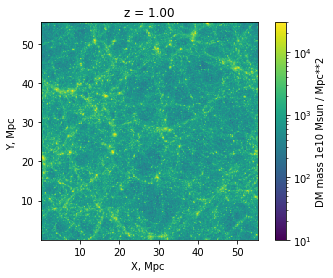

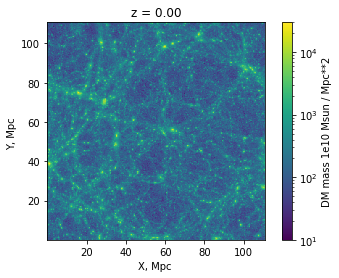

Elapsed time:  11.501198768615723


In [8]:
t0 = time.time()
for sn_id in snapshots:
    snapshot = data['Snapshots'][sn_id]
    norm=colors.LogNorm(10, 30000)
    particle_sampling = particle_sampling
    for bins in bins_list:
        axes = plt.subplot(aspect='equal')
        coords = snapshots_read[sn_id]
        xbin = (np.max(coords[:,0]) - np.min(coords[:,0]))/bins
        ybin = (np.max(coords[:,1]) - np.min(coords[:,1]))/bins
        _,_,_, histdata = axes.hist2d(
            coords[:,0]+0,
            coords[:,1]+0,
            bins=bins,
            norm=norm,
            weights=len(coords[:,0]) * [
                data['Header'].attrs['MassTable'][1] * particle_sampling / xbin / ybin
            ]
        )
        axes.set_xlabel(f"{xyzdict[0]} ")
        axes.set_ylabel(f"{xyzdict[1]} ")
        plt.colorbar(histdata, label="DM mass 1e10 Msun / Mpc**2")
        axes.set_title(f"z = {snapshot['Header'].attrs['Redshift']:.2f}")
        plt.savefig(f"dm_dens_{sn_id}.png")
        plt.show()
print("Elapsed time: ", time.time()-t0)

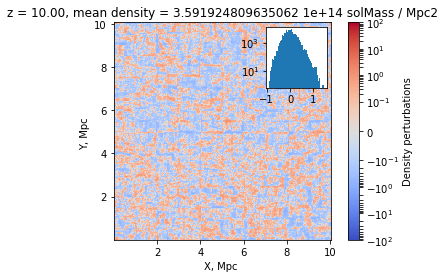

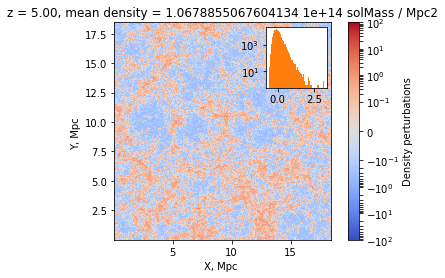

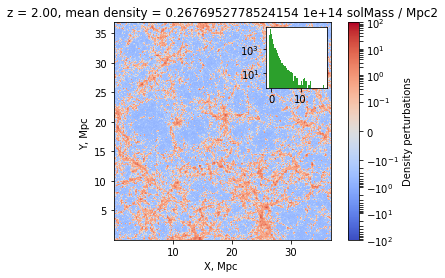

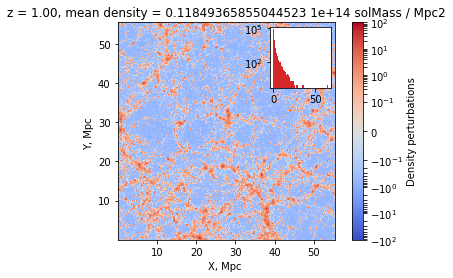

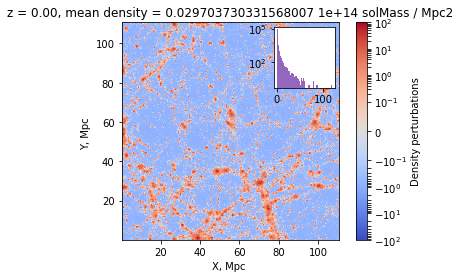

In [9]:
perturb_distribution = {}
t0 = time.time()
for sni, sn_id in enumerate(snapshots):
    snapshot = data['Snapshots'][sn_id]
    norm=colors.SymLogNorm(linthresh=0.1, linscale=1, vmin=-100, vmax=100, base=10)
    particle_sampling = particle_sampling
    for bins in bins_list:
        axes = plt.subplot(aspect='equal')
        coords = snapshots_read[sn_id]
        xbin = (np.max(coords[:,0]) - np.min(coords[:,0]))/bins
        ybin = (np.max(coords[:,1]) - np.min(coords[:,1]))/bins
        x = np.linspace(np.min(coords[:,0]),np.max(coords[:,0]),bins)
        y = np.linspace(np.min(coords[:,1]),np.max(coords[:,1]),bins)
        density = np.histogram2d(coords[:,0],coords[:,1], bins=[x,y])[0] \
                 * data['Header'].attrs['MassTable'][1] * particle_sampling / xbin / ybin
        density_mean = np.mean(density)
        density_perturb = (density - density_mean)/density_mean
        X, Y = np.meshgrid(x,y)
        histdata = axes.pcolorfast(X,Y,density_perturb,cmap="coolwarm", norm=norm)
        axes.set_xlabel(f"{xyzdict[0]} ")
        axes.set_ylabel(f"{xyzdict[1]} ")
        axin = axes.inset_axes([0.7, 0.7, 0.28, 0.28])
        axin.hist(density_perturb.flatten(), log=True, bins=50, color=f"C{sni}")
        perturb_distribution[sn_id] = np.histogram(density_perturb.flatten(), density=True, bins=100)
        plt.colorbar(histdata, label="Density perturbations")
        axes.set_title(f"z = {snapshot['Header'].attrs['Redshift']:.2f}, "
                       f"mean density = {(density_mean*1e10*u.Msun/(1*u.Mpc)**2).to(1e14*u.Msun/(1*u.Mpc)**2)}")
        plt.savefig(f"dm_perturb_{sn_id}.png")
        plt.show()

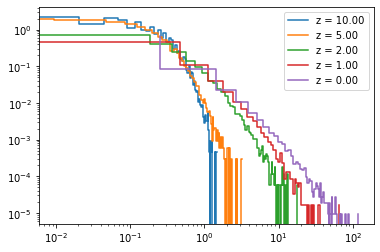

Elapsed time:  0.6352391242980957


In [10]:
t0 = time.time()
axes = plt.subplot()
for sni, sn_id in enumerate(snapshots):
    snapshot = data['Snapshots'][sn_id]
    # centroids = (perturb_distribution[sn_id][1][1:] + perturb_distribution[sn_id][1][:-1]) / 2
    axes.step(perturb_distribution[sn_id][1][1:], perturb_distribution[sn_id][0],color=f"C{sni}",label=f"z = {snapshot['Header'].attrs['Redshift']:.2f}")
axes.loglog()
axes.legend()
plt.show()
print("Elapsed time: ", time.time()-t0)


Group 1 mass:  {34870.42}
Group 20 mass:  {7500.2446}
Group 101 mass:  {1876.1267}
Group 1000 mass:  {186.92151}


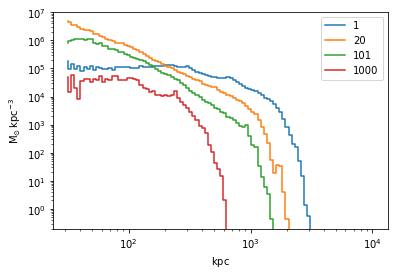

In [11]:
snapshot_id = 99
particle_sampling = 1
ax = plt.subplot()
for group in [1, 20, 101, 1000]:
    print(f"Group {group} mass: ",
              {data['Groups'][f'{snapshot_id}']['Group']['GroupMass'][group]})
    coords = comoving_to_physical(loadHalo(os.path.join(dir, "output"),snapshot_id, group, 1, 'Coordinates'))[::particle_sampling,:] * 1000 * u.kpc
    mass_center = np.mean(coords, axis=0)
    distance_to_mass_center = np.sqrt(np.sum((coords - mass_center)**2, axis=1))
    r_in = np.geomspace(3e-2, 10, 100) * 1000 * u.kpc
    hist, r = np.histogram(distance_to_mass_center, bins=r_in)
    r = r
    hist = hist * 1e10 * u.Msun
    density  = hist * data['Header'].attrs['MassTable'][1] * particle_sampling / (4 * np.pi * r[1:]**2 * (r[1:]-r[:-1]))
    ax.step(r[1:],density, label=group)
ax.legend()
ax.loglog()
# ax.set_ylim(1e5,1e14)
plt.show()

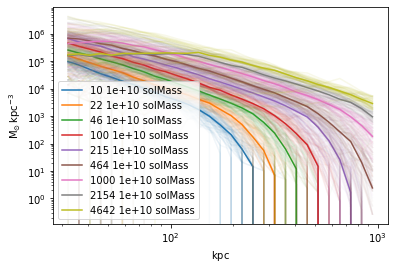

In [12]:

snapshot_id = 99
particle_sampling = 1
mass_boundaries = np.geomspace(1e11, 1e14, 10) * u.Msun
mass_array = np.array(data['Groups'][f'{snapshot_id}']['Group']['GroupMass']) * 1e10 * u.Msun

ax = plt.subplot()
for col, mass_boundary in enumerate(mass_boundaries[:-1]):
    valid_groups = np.argwhere((mass_boundaries[col] < mass_array) & (mass_boundaries[col+1] > mass_array))
    densities = []
    if len(valid_groups) > 100:
        valid_groups = random.choices(valid_groups, k=100)
    for group_nd in valid_groups:
        group = int(group_nd[0])
        # print(f"Group {group} mass: ",
        #           {data['Groups'][f'{snapshot_id}']['Group']['GroupMass'][group]})
        coords = comoving_to_physical(loadHalo(os.path.join(dir, "output"),snapshot_id, group, 1, 'Coordinates'))[::particle_sampling,:] * 1000 * u.kpc
        mass_center = np.mean(coords, axis=0)
        distance_to_mass_center = np.sqrt(np.sum((coords - mass_center)**2, axis=1))
        r_in = np.geomspace(3e-2, 1, 30) * 1000 * u.kpc
        hist, r = np.histogram(distance_to_mass_center, bins=r_in)
        r = r
        hist = hist * 1e10 * u.Msun
        density  = hist * data['Header'].attrs['MassTable'][1] * particle_sampling / (4 * np.pi * r[1:]**2 * (r[1:]-r[:-1]))
        center = 0.5 * (r[1:] + r[:-1])
        ax.plot(center, density, alpha=3/len(valid_groups), color=f"C{col%10}")
        densities.append(density)
    mean_density = np.median(densities, axis=0)
    ax.plot(center, mean_density, color=f"C{col%10}", label = "{q.value:.0f} {q.unit}".format(q=mass_boundary.to(1e10*u.Msun)))
    ax.loglog()
    ax.legend()
# ax.set_ylim(1e5,1e14)
plt.show()


In [13]:
def einasto(x, coef, slope, alpha):
    return coef * np.exp(-slope * x ** alpha)

@dataclass
class Fitter:
    function: Literal["Einasto", "Navarro-Frenk-White"] = "Einasto"
    x: np.ndarray = None
    y: np.ndarray = None

    def einasto(self, p, x=None):
        if x is None: x = self.x
        return p[0] * np.exp(-p[1] * x ** p[2])

    def _lnlike_einasto(self, param):
        return -0.5 * np.sum((self.einasto(param) - self.y) ** 2)

    def __call__(self, x0=[1,1,0]):
        out_sp = scipy.optimize.minimize(
            lambda *args: -self._lnlike_einasto(*args),
            x0, method = 'Nelder-Mead', options={'maxiterint':10000}
        )
        self.out_sp = out_sp
        return out_sp

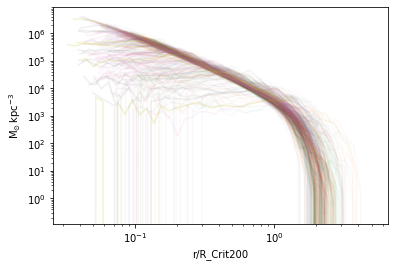

In [14]:
mass_boundaries = np.geomspace(1e12, 1e14, 10) * u.Msun
ax = plt.subplot()
simulation_size = comoving_to_physical(75000) * 1000 * u.kpc
densities = []
radii_scaled = []
for col, mass_boundary in enumerate(mass_boundaries[:-1]):
    valid_groups = np.argwhere((mass_boundaries[col] < mass_array) & (mass_boundaries[col+1] > mass_array))
    if len(valid_groups) > 100:
        valid_groups = random.choices(valid_groups, k=100)
    for group_nd in valid_groups:
        group = int(group_nd[0])
        # print(f"Group {group} mass: ",
        #           {data['Groups'][f'{snapshot_id}']['Group']['GroupMass'][group]})

        radius_200 = comoving_to_physical(data['Groups'][f'{snapshot_id}']['Group']['Group_R_Crit200'][group])*1000*u.kpc
        coords = comoving_to_physical(loadHalo(os.path.join(dir, "output"),snapshot_id, group, 1, 'Coordinates'))[::particle_sampling,:] * 1000 * u.kpc
        mass_center = np.mean(coords, axis=0)
        if np.any(coords < radius_200*10) or np.any(coords > simulation_size - radius_200*10):
            # print("Removing group ", group)
            continue
        distance_to_mass_center = np.sqrt(np.sum((coords - mass_center)**2, axis=1))
        r_in = np.geomspace(3e-2, 1, 30) * 1000 * u.kpc
        hist, r = np.histogram(distance_to_mass_center, bins=r_in)
        hist = hist * 1e10 * u.Msun
        density  = hist * data['Header'].attrs['MassTable'][1] * particle_sampling / (4 * np.pi * r[1:]**2 * (r[1:]-r[:-1]))
        center = 0.5 * (r[1:] + r[:-1])
        ax.plot(center/radius_200, density, alpha=3/len(valid_groups), color=f"C{col%10}")
        densities.append(density)
        radii_scaled.append(center/radius_200)
    mean_density = np.median(densities, axis=0)
    # ax.plot(center, mean_density, color=f"C{col%10}", label = "{q.value:.0f} {q.unit}".format(q=mass_boundary.to(1e10*u.Msun)))
ax.set_xlabel("r/R_Crit200")
ax.loglog()
all_densities = np.array(densities).flatten() * densities[0].unit
all_radii_scaled = np.array(radii_scaled).flatten()
plt.show()

[4.71321050e+07 9.73383255e+00 3.34877811e-01]
[5.22541173e+05 3.07304990e+05 1.69759011e+05 8.74388651e+04
 4.16486526e+04 1.81767365e+04 7.19400470e+03 2.55245795e+03
 8.01460998e+02 2.19525486e+02]


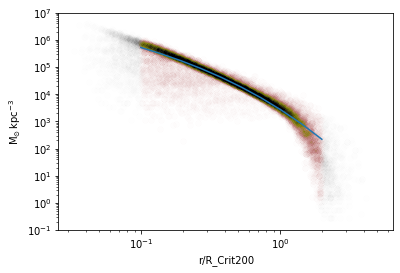

In [15]:
ax = plt.subplot()
indices = (all_radii_scaled<2) & (all_radii_scaled>0.1) & (all_densities>1*u.Msun/u.kpc**3)
ax.scatter(all_radii_scaled, all_densities, alpha=0.005, color="k")
ax.scatter(all_radii_scaled[indices], all_densities[indices], alpha=0.005, color="C1")
ax.set_xlabel("r/R_Crit200")
ax.loglog()
ax.set_ylim([1e-1,1e7])

touse_radii_scaled = all_radii_scaled[indices]
touse_densities = all_densities[indices]

# fit = Fitter(x=all_radii_scaled[indices], y=np.log10(all_densities[indices].value))
# print(fit.x, fit.y)
# out = fit(x0=[7,1,0])


r = np.geomspace(0.1,2,10)
# centers = [np.sqrt(rfirst*rlast) for rfirst, rlast in zip(r[:-1], r[1:])]
# median_densities = [
#     np.median(
#         touse_densities[
#                   (touse_radii_scaled > rfirst)
#                   & (touse_radii_scaled < rlast)
#         ],
#     )
#     for rfirst, rlast in zip(r[:-1], r[1:])
# ]
# print(median_densities)
# ax.loglog(centers, median_densities)
fit = scipy.optimize.curve_fit(
    einasto, touse_radii_scaled, touse_densities / all_densities.unit,
    p0=[1e9,1,0],
    # method='trf'
)
print(fit[0])
print(einasto(r, *fit[0]))
ax.loglog(r, einasto(r, *fit[0])*all_densities.unit, color="C0")
plt.show()